**This notebook focuses on the effectiveness of Spatial Smoothing against adversarial attacks on the MNIST dataset.**

## **Section 0 - Setting Up**

### **Load prerequisites**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from art import config
from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool, BasicIterativeMethod
from art.defences.preprocessor import SpatialSmoothing
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier, TensorFlowV2Classifier
from art.utils import load_mnist

### **Disable eager execution to enable adversarial crafting and ART classifier**

In [2]:
tf.compat.v1.disable_eager_execution()

### **Load MNIST dataset**

In [3]:
(x_train_cln, y_train_cln), (x_test_cln, y_test_cln), min_pixel_value, max_pixel_value = load_mnist()
# x_test_cln, y_test_cln = x_test_cln[:50], y_test_cln[:50]

### **Create MNIST classifier model**

*Load MNIST pre-trained model*

In [4]:
model = load_model("/home/cyber/mnist_trained_model.h5")

*Create ART classifier*

In [5]:
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

## **Section 1 - Attack**

Step 1: Evaluate the classifier on the clean test set

In [6]:
predictions_cln = classifier.predict(x_test_cln)
accuracy_cln = np.sum(np.argmax(predictions_cln, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on clean test examples: {}%".format(accuracy_cln * 100))

/home/cyber/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on clean test examples: 99.11%


Step 2: Split clean test examples into true and false positives

In [7]:
tp_cln_indexes=[]
fp_cln_indexes=[]
x_test_cln_tp=[]
y_test_cln_tp=[]
x_test_cln_fp=[]
y_test_cln_fp=[]

for k in range(len(predictions_cln)):
    if(np.argmax(predictions_cln, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_cln_indexes.append(k)
    else:
        fp_cln_indexes.append(k)

for k in tp_cln_indexes:
    x_test_cln_tp.append(x_test_cln[k])
    y_test_cln_tp.append(y_test_cln[k])
    
for k in fp_cln_indexes:
    x_test_cln_fp.append(x_test_cln[k])
    y_test_cln_fp.append(y_test_cln[k])
    
x_test_cln_tp = np.array(x_test_cln_tp)
x_test_cln_fp = np.array(x_test_cln_fp)

print('Number of clean true positives: {:}'.format(len(x_test_cln_tp)))
print('Number of clean false positives: {:}'.format(len(x_test_cln_fp)))

Number of clean true positives: 9911
Number of clean false positives: 89


Step 3: Craft adversarial examples

*Craft Jacobian-based Saliency Map Attack (JSMA) attacks*

In [8]:
# adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 0.1, gamma=0.3, verbose=True)
# x_test_JSMA_MNIST = adv_crafter.generate(x_test_cln)
# %store x_test_JSMA_MNIST

*Craft Basic Iterative Method (BMI) attacks*

In [9]:
# adv_crafter = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.1, max_iter=100)
# x_test_BIM_MNIST = adv_crafter.generate(x_test_cln)
# %store x_test_BIM_MNIST

*Craft Projected Gradient Descent (PGD) attacks*

In [10]:
# adv_crafter = ProjectedGradientDescent(classifier, eps=0.3, eps_step=0.1, max_iter=100)
# x_test_PGD_MNIST = adv_crafter.generate(x_test_cln)
# %store x_test_PGD_MNIST

*Craft NewtonFool attacks*

In [11]:
# adv_crafter =  NewtonFool(classifier=classifier, eta=0.05, max_iter=100, verbose=True)
# x_test_Newton_MNIST = adv_crafter.generate(x_test_cln)
# %store x_test_Newton_MNIST

*Craft DeepFool attacks*

In [12]:
# adv_crafter = DeepFool(classifier=classifier, epsilon=1e-06, max_iter=100)
# x_test_Deep_MNIST = adv_crafter.generate(x_test_cln)
# %store x_test_Deep_MNIST

*Alternatively, load existing adversarial attacks*

In [139]:
attack_name = 'BIM'
%store -r x_test_BIM_MNIST
x_test_adv = x_test_BIM_MNIST

Step 4: Evaluate the classifier on the adversarial test set

In [140]:
predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Accuracy on adversarial test examples: 0.7100000000000001%


Step 5: Split the adversarial test examples into true and false positives

In [141]:
tp_adv_indexes=[]
fp_adv_indexes=[]
x_test_adv_tp=[]
y_test_adv_tp=[]
x_test_adv_fp=[]
y_test_adv_fp=[]

for k in range(len(predictions_adv)):
    if(np.argmax(predictions_adv, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_adv_indexes.append(k)
    else:
        fp_adv_indexes.append(k)

for k in tp_adv_indexes:
    x_test_adv_tp.append(x_test_adv[k])
    y_test_adv_tp.append(y_test_cln[k])
    
for k in fp_adv_indexes:
    x_test_adv_fp.append(x_test_adv[k])
    y_test_adv_fp.append(y_test_cln[k])
    
x_test_adv_tp = np.array(x_test_adv_tp)
x_test_adv_fp = np.array(x_test_adv_fp)

print('Adversarial TP: {:}'.format(len(x_test_adv_tp)))
print('Adversarial FP: {:}'.format(len(x_test_adv_fp)))

Adversarial TP: 71
Adversarial FP: 9929


Step 6: Plot clean test examples and their adversarial counterparts

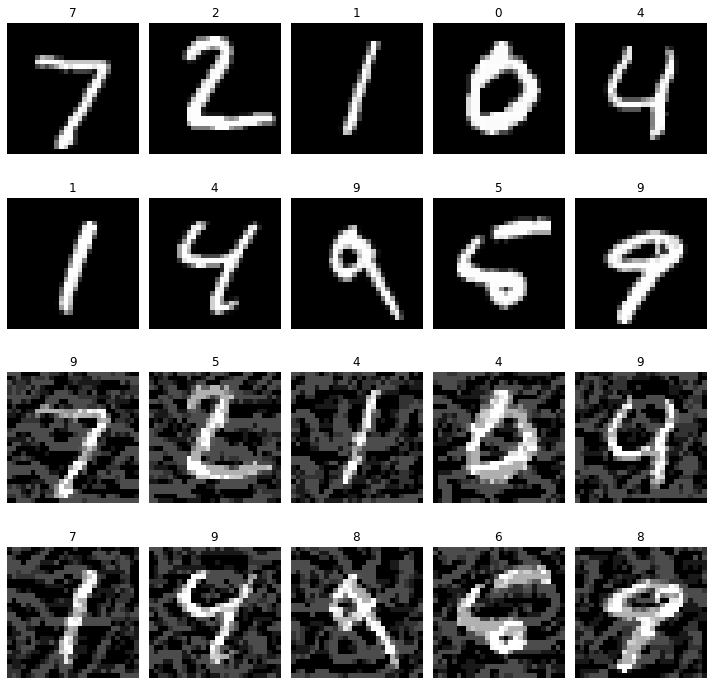

In [142]:
# Plot images
plt.figure(figsize=(10, 10))

for i in range(10):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(x_test_cln[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[i]))
    plt.axis("off")
    
    ax = plt.subplot(4, 5, i + 11)
    plt.imshow(x_test_adv[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(predictions_adv,axis=1)[i]))
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## **Section 2 - Defence**

### **Spatial Smoothing**

Step 1: Transform input

In [143]:
defence = SpatialSmoothing(window_size=3)

In [144]:
x_test_cln_tp_ss = defence(x_test_cln_tp)[0]
x_test_cln_fp_ss = defence(x_test_cln_fp)[0]
x_test_cln_ss = np.concatenate((x_test_cln_tp_ss, x_test_cln_fp_ss), axis=0)
y_test_cln_ss = y_test_cln_tp + y_test_cln_fp

In [145]:
x_test_adv_tp_ss = defence(x_test_adv_tp)[0]
x_test_adv_fp_ss = defence(x_test_adv_fp)[0]
x_test_adv_ss = np.concatenate((x_test_adv_tp_ss, x_test_adv_fp_ss), axis=0)
y_test_adv_ss = y_test_adv_tp + y_test_adv_fp

Step 2: Evaluate the classifier on all 4 sets of data after SpatialSmoothing

In [146]:
predictions_cln_ss = classifier.predict(x_test_cln_ss)
accuracy_cln_ss = np.sum(np.argmax(predictions_cln_ss, axis=1) == np.argmax(y_test_cln_ss, axis=1)) / len(y_test_cln_ss)

print("Effect of Spatial Smoothing on entire clean test set: {:.2f}%".format((accuracy_cln_ss - accuracy_cln) * 100))
 
predictions_cln_tp_ss = classifier.predict(x_test_cln_tp_ss)
accuracy_cln_tp_ss = np.sum(np.argmax(predictions_cln_tp_ss, axis=1) == np.argmax(y_test_cln_tp, axis=1)) / len(y_test_cln_tp)

# print("\nAccuracy on true positive clean test examples after Spatial Smoothing: {:.2f}%".format(accuracy_cln_tp_ss * 100))
print("\nAccuracy drop on true positive clean test examples after Spatial Smoothing: {:.2f}%".format((1 - accuracy_cln_tp_ss) * 100))

predictions_cln_fp_ss = classifier.predict(x_test_cln_fp_ss)
accuracy_cln_fp_ss = np.sum(np.argmax(predictions_cln_fp_ss, axis=1) == np.argmax(y_test_cln_fp, axis=1)) / len(y_test_cln_fp)

print("\nAccuracy increase on false positive clean test examples after Spatial Smoothing: {:.2f}%".format(accuracy_cln_fp_ss * 100))

predictions_adv_ss = classifier.predict(x_test_adv_ss)
accuracy_adv_ss = np.sum(np.argmax(predictions_adv_ss, axis=1) == np.argmax(y_test_adv_ss, axis=1)) / len(y_test_adv_ss)

print("\nEffect of Spatial Smoothing on entire adversarial test set: {:.2f}%".format((accuracy_adv_ss-accuracy_adv) * 100))

predictions_adv_tp_ss = classifier.predict(x_test_adv_tp_ss)
accuracy_adv_tp_ss = np.sum(np.argmax(predictions_adv_tp_ss, axis=1) == np.argmax(y_test_adv_tp, axis=1)) / len(y_test_adv_tp)

# print("\nAccuracy on true positive adversarial test examples after Spatial Smoothing: {:.2f}%".format(accuracy_adv_tp_ss * 100))
print("\nAccuracy drop on true positive adversarial test examples after Spatial Smoothing: {:.2f}%".format((1 - accuracy_adv_tp_ss) * 100))

predictions_adv_fp_ss = classifier.predict(x_test_adv_fp_ss)
accuracy_adv_fp_ss = np.sum(np.argmax(predictions_adv_fp_ss, axis=1) == np.argmax(y_test_adv_fp, axis=1)) / len(y_test_adv_fp)

print("\nAccuracy increase on false positive adversarial test examples after Spatial Smoothing: {:.2f}%".format(accuracy_adv_fp_ss * 100))

Effect of Spatial Smoothing on entire clean test set: -0.66%

Accuracy drop on true positive clean test examples after Spatial Smoothing: 0.85%

Accuracy increase on false positive clean test examples after Spatial Smoothing: 20.22%

Effect of Spatial Smoothing on entire adversarial test set: 0.39%

Accuracy drop on true positive adversarial test examples after Spatial Smoothing: 0.00%

Accuracy increase on false positive adversarial test examples after Spatial Smoothing: 0.39%


Step 3: Plot all data pre- and post-transformation

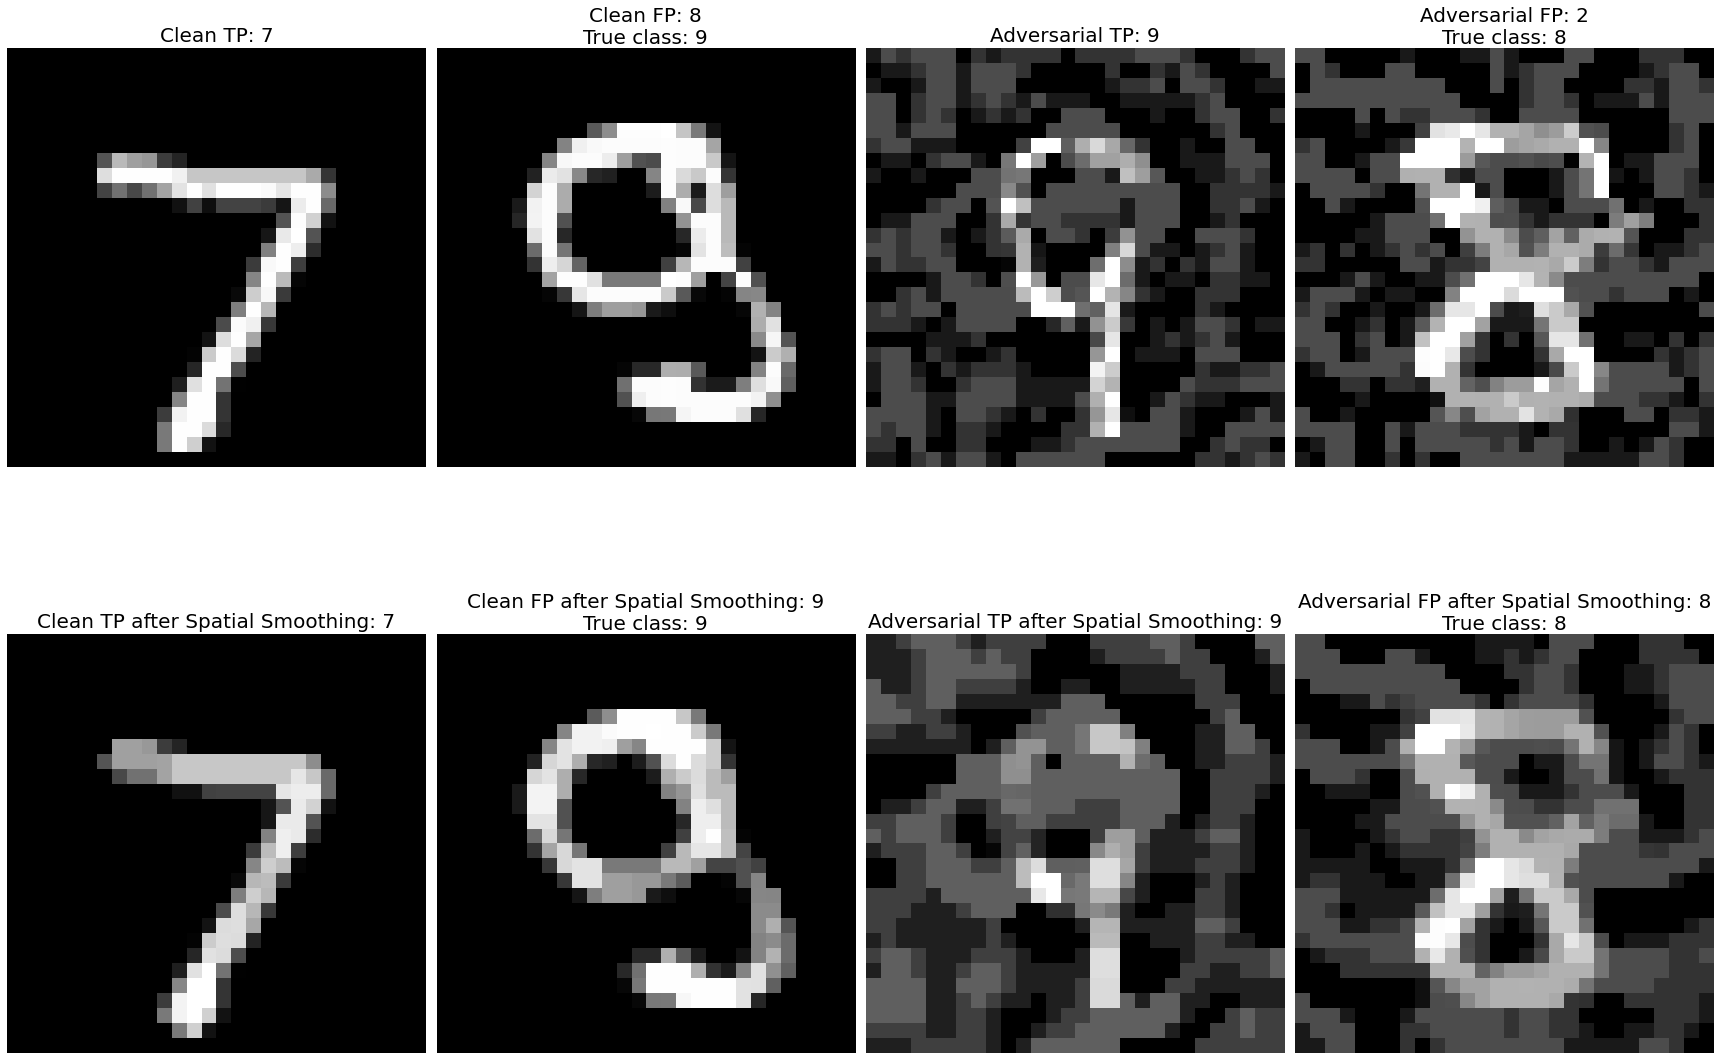

In [147]:
# Get index of successful Spatial Smoothing transformations
succ_cln_tp_idx=[]
succ_cln_fp_idx=[]
succ_adv_tp_idx=[]
succ_adv_fp_idx=[]


for k in range(len(predictions_cln_tp_ss)):
    if(np.argmax(predictions_cln_tp_ss, axis=1)[k] == np.argmax(y_test_cln_tp, axis=1)[k]):
        succ_cln_tp_idx.append(k)
        
for k in range(len(predictions_cln_fp_ss)):
    if(np.argmax(predictions_cln_fp_ss, axis=1)[k] == np.argmax(y_test_cln_fp, axis=1)[k]):
        succ_cln_fp_idx.append(k)
        
for k in range(len(predictions_adv_tp_ss)):
    if(np.argmax(predictions_adv_tp_ss, axis=1)[k] == np.argmax(y_test_adv_tp, axis=1)[k]):
        succ_adv_tp_idx.append(k)
        
for k in range(len(predictions_adv_fp_ss)):
    if(np.argmax(predictions_adv_fp_ss, axis=1)[k] == np.argmax(y_test_adv_fp, axis=1)[k]):
        succ_adv_fp_idx.append(k)
        
# Get predictions of data before transformation

predictions_cln_tp = classifier.predict(x_test_cln_tp)
predictions_cln_fp = classifier.predict(x_test_cln_fp)
predictions_adv_tp = classifier.predict(x_test_adv_tp)
predictions_adv_fp = classifier.predict(x_test_adv_fp)

#plot images
plt.figure(figsize=(24,18))

#Plot clean true positives
ax = plt.subplot(2, 4, 1)
plt.imshow(x_test_cln_tp[succ_cln_tp_idx[0]], cmap='gray')
ax.set_title('Clean TP: {:}'.format(np.argmax(predictions_cln_tp,axis=1)[succ_cln_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 1+4)
plt.imshow(x_test_cln_tp_ss[succ_cln_tp_idx[0]], cmap='gray')
ax.set_title('Clean TP after Spatial Smoothing: {:}'.format(np.argmax(predictions_cln_tp_ss,axis=1)[succ_cln_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot clean false positives
ax = plt.subplot(2, 4, 2)
plt.imshow(x_test_cln_fp[succ_cln_fp_idx[0]], cmap='gray')
ax.set_title('Clean FP: {:}\nTrue class: {:}'.format(np.argmax(predictions_cln_fp,axis=1)[succ_cln_fp_idx[0]], np.argmax(y_test_cln_fp,axis=1)[succ_cln_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 2+4)
plt.imshow(x_test_cln_fp_ss[succ_cln_fp_idx[0]], cmap='gray')
ax.set_title('Clean FP after Spatial Smoothing: {:}\nTrue class: {:}'.format(np.argmax(predictions_cln_fp_ss,axis=1)[succ_cln_fp_idx[0]], np.argmax(y_test_cln_fp,axis=1)[succ_cln_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot adversarial true positives
ax = plt.subplot(2, 4, 3)
plt.imshow(x_test_adv_tp[succ_adv_tp_idx[0]], cmap='gray')
ax.set_title('Adversarial TP: {:}'.format(np.argmax(predictions_adv_tp,axis=1)[succ_adv_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 3+4)
plt.imshow(x_test_adv_tp_ss[succ_adv_tp_idx[0]], cmap='gray')
ax.set_title('Adversarial TP after Spatial Smoothing: {:}'.format(np.argmax(predictions_adv_tp_ss,axis=1)[succ_adv_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot adversarial false positivies
ax = plt.subplot(2, 4, 4)
plt.imshow(x_test_adv_fp[succ_adv_fp_idx[0]], cmap='gray')
ax.set_title('Adversarial FP: {:}\nTrue class: {:}'.format(np.argmax(predictions_adv_fp,axis=1)[succ_adv_fp_idx[0]], np.argmax(y_test_adv_fp,axis=1)[succ_adv_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 4+4)
plt.imshow(x_test_adv_fp_ss[succ_adv_fp_idx[0]], cmap='gray')
ax.set_title('Adversarial FP after Spatial Smoothing: {:}\nTrue class: {:}'.format(np.argmax(predictions_adv_fp_ss,axis=1)[succ_adv_fp_idx[0]], np.argmax(y_test_adv_fp,axis=1)[succ_adv_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

image_path = '/home/cyber/Desktop/Adrian/Plots/SpatialSmoothing_MNIST_{:}.png'.format(attack_name)
plt.savefig(image_path, dpi=500, transparent=True)
plt.tight_layout()
plt.show()

## Others

Optional step: Compare the performance of SpatialSmoothing against the adversary over a range of eps values

In [ ]:
# eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# accuracy_original = []
# accuracy_robust = []

# adv_crafter = FastGradientMethod(classifier)
# adv_crafter_robust = FastGradientMethod(robust_classifier)

# for eps in eps_range:
#     adv_crafter.set_params(**{'eps': eps})
#     adv_crafter_robust.set_params(**{'eps': eps})
#     x_test_adv = adv_crafter.generate(x_test[:100])
#     x_test_adv_robust = adv_crafter_robust.generate(x_test[:100])
    
#     predictions_original = np.argmax(classifier.predict(x_test_adv), axis=1)
#     accuracy_original += [np.sum(predictions_original == np.argmax(y_test[:100], axis=1))]
    
#     predictions_robust = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
#     accuracy_robust += [np.sum(predictions_robust == np.argmax(y_test[:100], axis=1))]

# eps_range = eps_range

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(np.array(eps_range), np.array(accuracy_original), 'b--', label='Original classifier')
# ax.plot(np.array(eps_range), np.array(accuracy_robust), 'r--', label='Robust classifier')

# legend = ax.legend(loc='upper right', shadow=True, fontsize='large')
# #legend.get_frame().set_facecolor('#00FFCC')

# plt.xlBIMabel('Attack strength (eps)')
# plt.ylabel('Accuracy (%)')
# plt.show()

Optional step: Ensure that the clean and adversarial test sets are split correctly into their true and false positivies

In [ ]:
# predictions_cln_tp = classifier.predict(x_test_cln_tp)
# accuracy = np.sum(np.argmax(predictions_cln_tp, axis=1) == np.argmax(y_test_cln_tp, axis=1)) / len(y_test_cln_tp)

# print("Accuracy on true positive clean test examples: {}%".format(accuracy * 100))

# predictions_cln_fp = classifier.predict(x_test_cln_fp)
# accuracy = np.sum(np.argmax(predictions_cln_fp, axis=1) == np.argmax(y_test_cln_fp, axis=1)) / len(y_test_cln_fp)

# print("Accuracy on false positive clean test examples: {}%".format(accuracy * 100))

# predictions_adv_tp = classifier.predict(x_test_adv_tp)
# accuracy = np.sum(np.argmax(predictions_adv_tp, axis=1) == np.argmax(y_test_adv_tp, axis=1)) / len(y_test_adv_tp)

# print("Accuracy on true positive adversarial test examples: {}%".format(accuracy * 100))

# predictions_adv_fp = classifier.predict(x_test_adv_fp)
# accuracy = np.sum(np.argmax(predictions_adv_fp, axis=1) == np.argmax(y_test_adv_fp, axis=1)) / len(y_test_adv_fp)

# print("Accuracy on false positive adversarial test examples: {}%".format(accuracy * 100))